In [1]:
imports_path = ".\\imports.ipynb"
tableGAN_path = ".\\tableGAN.ipynb"
utils_path = ".\\utils.ipynb"

%run "$imports_path"

In [17]:
%run "$utils_path"
%run "$tableGAN_path"
%load_ext line_profiler
data= pd.read_csv('Datasets\\df_adult_edited.csv')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [18]:
n_epochs = 20
n_critic = 10
adam_lr = 0.002
adam_beta1 = 0.5
model_dir = ".\\Model\\tableGAN_ckpt\\compare_adult\\"
noise_discrete_unif_max = 0

batch_size = 500
ckpt_every = 1
loss_plot_update_every = 10

image_dir = ".\\Images"
timer_dir = ".\\Timers"
dataset_dir = ".\\Datasets"
retrain = True

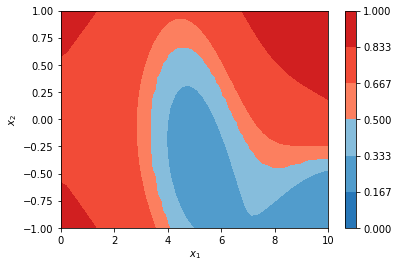

In [19]:
n_cols = 6
# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = matplotlib.cm.get_cmap('Blues_r')(np.linspace(0.2, 0.6, n_cols))
colors2 = matplotlib.cm.get_cmap('Reds')(np.linspace(0.4, 0.8, n_cols))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cmap_br = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

def classifier_func(x1, x2):
    a = 0.1 * (x1 - 5)**2 + (x2)**2 - 0.5 + 0.2 * tf.sqrt(x1) - 0.1*x1 + 0.005*x1**3 * x2 + 0.5*np.sin(x1) + 0.3*np.cos(x2)
    b = tf.sign(a) * (tf.abs(a))**(1/2)
    return(tf.math.sigmoid(b).numpy())


fig, ax = plt.subplots()
def plot_heatmap(ax, heat_map_res = 50, incl_axis_labels = True, incl_colorbar = True, ret_contour = True):
    x1 = np.linspace(0, 10, heat_map_res)
    x2 = np.linspace(-1, 1, heat_map_res)
    x1_mesh, x2_mesh = np.meshgrid(x1, x2)
    
    y_mesh = classifier_func(x1_mesh, x2_mesh)
    cont1 = ax.contourf(x1_mesh, x2_mesh, y_mesh, levels = np.linspace(0, 1, n_cols + 1), cmap = cmap_br)
    if (incl_axis_labels):
        ax.set_xlabel(r"$x_1$")
        ax.set_ylabel(r"$x_2$")
    if incl_colorbar:
        plt.colorbar(cont1, ax = ax)
    if ret_contour:
        return cont1

plot_heatmap(ax)
plt.savefig(os.path.join(image_dir, "prediction_func_for_cf_testing.jpg"))

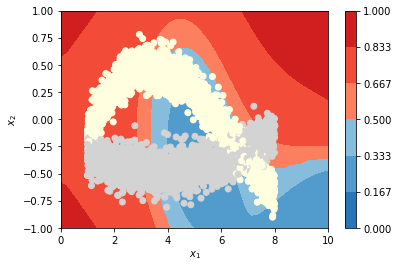

In [20]:
def classifier(data):
    return(classifier_func(data["x1"], data["x2"]))

n_train = 5000

x1_low, x1_high = 1,8
np.random.seed(1)
x1 = np.random.uniform(x1_low, x1_high, n_train)
x3 = np.random.choice(["0","1"], n_train)
sigma = 0.10

def dist_x2_given_x1(x1,x3):
    return np.where(x3 == "1",
                    0.01*(x1)**3 - 0.2*x1**2 + x1 - 1,
                    0.02*x1**2 - 0.15*x1 -0.2
                   )

def conf_int_x2_given_x1(x1_low, x1_high, x3, sigma, alpha = 0.05, n_steps = 100):
    x1 = np.linspace(x1_low, x1_high, n_steps)
    mean = dist_x2_given_x1(x1, x3)
    return(x1, scipy.stats.norm.interval(1-alpha, loc=mean, scale=sigma))

x2 = np.random.normal(dist_x2_given_x1(x1, x3), sigma, n_train)
df_toy = pd.DataFrame({"x1" : x1, "x2" : x2, "x3" : x3})
df_toy.to_csv(os.path.join(dataset_dir, "df_toy.csv"), index=False)

def plot_confint_x2_given_x1_and_x3(ax, alpha = 0.05):
    x1_grid, x2_confint = conf_int_x2_given_x1(x1_low, x1_high, "0", sigma, alpha =alpha)
    ax.plot(x1_grid, x2_confint[0], c= "lightgrey", linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = "lightgrey", linestyle = "dashed")
    x1_grid, x2_confint = conf_int_x2_given_x1(x1_low, x1_high, "1", sigma, alpha = alpha)
    ax.plot(x1_grid, x2_confint[0], c= "lightyellow", linestyle = "dashed")
    ax.plot(x1_grid, x2_confint[1], c = "lightyellow", linestyle = "dashed")

fig, ax = plt.subplots()

map_x3_to_col = lambda data : np.where(data["x3"] == "1", "lightyellow", "lightgrey")

plot_heatmap(ax)
plt.scatter(df_toy["x1"], df_toy["x2"], color = map_x3_to_col(df_toy))
#plot_confint_x2_given_x1_and_x3(ax)
plt.savefig(os.path.join(image_dir, "toy_dataset_for_cf_testing.jpg"))

In [27]:
%run "$tableGAN_path"
tg = TableGAN(df_toy, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = 0, adam_beta2 = 0.999,
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

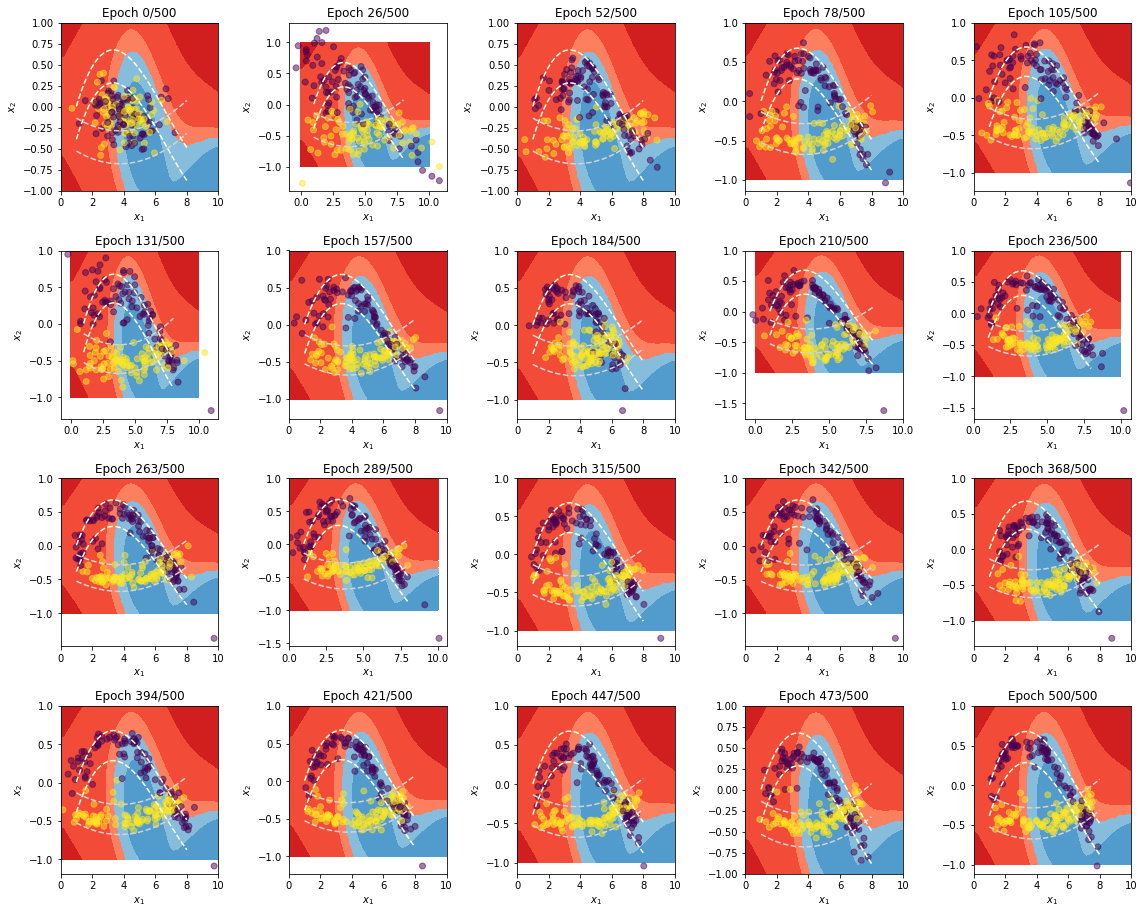

In [29]:
tg.train(n_epochs = 500, batch_size = 500, restart_training = True, loss_plot_update_every = loss_plot_update_every,
             loss_plot_type = "line", progress_bar=True, plot2D_image = True, plot_loss = False, n_test=200,
         plot2D_discrete_col="x3",
         plot2D_background_func = lambda ax : (plot_heatmap(ax, incl_colorbar = False, ret_contour = False),
                                               plot_confint_x2_given_x1_and_x3(ax)))

In [603]:
%lprun -f fast_non_dominated_sort a = tg.generate_counterfactuals(50, classifier, tg.data.loc[0], n_to_generate = 10000, add_plausibility_objective =True)

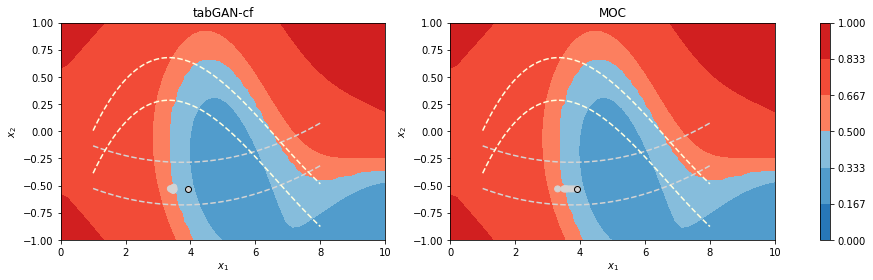

In [30]:
cf_dir = ".//Counterfactuals"

compare_counterfactuals(df_toy, x_obs_nr = 0, save_path = "compare_counterfactuals_for_obs0.jpg", save_dir=image_dir)

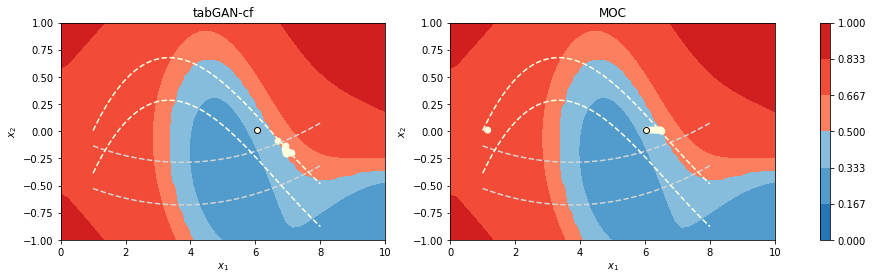

In [31]:
compare_counterfactuals(df_toy, x_obs_nr=1, save_path = "compare_counterfactuals_for_obs1.jpg", save_dir=image_dir)